## this homework 1 for machine learning lecture

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.svm as svm
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score, cross_val_predict, KFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
import scipy.spatial.distance
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_confusion_matrix, roc_curve, auc
import seaborn as sns


In [113]:
## implementation of knn classsifer without sklearn whic takes k and metric params
class KNNClassifier:

    def __init__(self, k=5, metric='euclidean'):
        self.k = k
        self.metric = metric
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.classes = None

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.classes = np.unique(y_train)
        return self

    def predict(self, X_test):
        self.X_test = X_test
        y_pred = []
        for i in range(self.X_test.shape[0]):
            # calculate distances
            distances = scipy.spatial.distance.cdist(self.X_train,
                                                     self.X_test[i, :].reshape(
                                                         1, -1),
                                                     metric=self.metric)
            # sort the distances
            sorted_indices = np.argsort(distances, axis=0)
            # get the indices of the k nearest neighbors
            k_nearest_indices = sorted_indices[:self.k]
            # get the classes of the k nearest neighbors
            # print(k_nearest_indices.flatten())
            k_nearest_classes = [
                self.y_train.iloc[i] for i in k_nearest_indices.flatten()
            ]

            # get the most common class
            most_common_class = Counter(k_nearest_classes).most_common(1)[0][0]
            y_pred.append(most_common_class)
        return y_pred

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return np.sum(y_pred == y_test) / len(y_test)


In [114]:
bank_data = pd.read_csv('bank.csv', sep=';')
bank_data = bank_data.dropna().drop(['month','day'],axis=1)

Y = bank_data['y']
X = bank_data.drop(['y'], axis=1)
X

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,30,unemployed,married,primary,no,1787,no,no,cellular,79,1,-1,0,unknown
1,33,services,married,secondary,no,4789,yes,yes,cellular,220,1,339,4,failure
2,35,management,single,tertiary,no,1350,yes,no,cellular,185,1,330,1,failure
3,30,management,married,tertiary,no,1476,yes,yes,unknown,199,4,-1,0,unknown
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,226,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,329,5,-1,0,unknown
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,153,1,-1,0,unknown
4518,57,technician,married,secondary,no,295,no,no,cellular,151,11,-1,0,unknown
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,129,4,211,3,other


In [115]:
ordinalEncoder = OrdinalEncoder()
oneHotEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
labelEncoder = LabelEncoder()

column_transformer = make_column_transformer(
    (ordinalEncoder, ['education', 'poutcome']), (oneHotEncoder, [
        'job',
        'housing',
        'marital',
        'default',
        'loan',
        'contact',
    ]),
    remainder='passthrough')

X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
)


## KNN WITH EUCLIDEAN

Accuracy: 87.583% (1.495%)
              precision    recall  f1-score   support

          no       0.90      0.97      0.93      3194
         yes       0.43      0.20      0.27       422

    accuracy                           0.88      3616
   macro avg       0.67      0.58      0.60      3616
weighted avg       0.85      0.88      0.86      3616



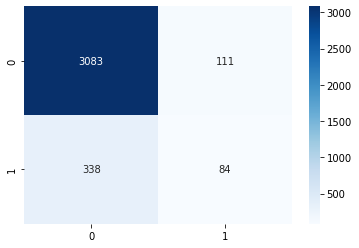

In [129]:
pipeline = Pipeline([('column_transformer', column_transformer),
                     ('scaler', StandardScaler()),
                     ('classifier', KNNClassifier(k=4, metric='euclidean'))])

pipeline.fit(X_train, y_train)
# k-fold cross validation
k_fold = KFold(n_splits=10, shuffle=True)

results = cross_val_score(pipeline, X_train, y_train, cv=k_fold)
print("Accuracy: %.3f%% (%.3f%%)" %
      (results.mean() * 100, results.std() * 100))

y_pred = cross_val_predict(pipeline, X_train, y_train, cv=k_fold)
cm=confusion_matrix(y_train, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
print(classification_report(y_train, y_pred))




## KNN WITH MANHATTAN



Accuracy: 87.639% (1.692%)
              precision    recall  f1-score   support

          no       0.90      0.97      0.93      3194
         yes       0.45      0.19      0.27       422

    accuracy                           0.88      3616
   macro avg       0.68      0.58      0.60      3616
weighted avg       0.85      0.88      0.86      3616



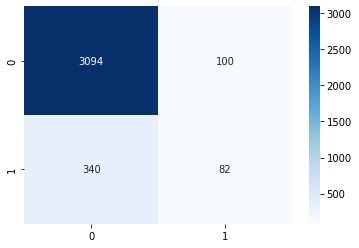

In [130]:
pipeline = Pipeline([('column_transformer', column_transformer),
                     ('scaler', StandardScaler()),
                     ('classifier', KNNClassifier(k=4, metric='cityblock'))])

pipeline.fit(X_train, y_train)
# k-fold cross validation
k_fold = KFold(n_splits=10, shuffle=True)

results = cross_val_score(pipeline, X_train, y_train, cv=k_fold)
print("Accuracy: %.3f%% (%.3f%%)" %
      (results.mean() * 100, results.std() * 100))

y_pred = cross_val_predict(pipeline, X_train, y_train, cv=k_fold)
cm = confusion_matrix(y_train, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
print(classification_report(y_train, y_pred))


## SVM

In [133]:
## You may use an available implementation of SVM in Python.
# o Report performance using an appropriate k-fold cross validation using ROC curves and
# confusion matrices. Find the best threshold for the SVM output as described in the
# note by Fawcett.
# o Report the run time performance of your above tests.


pipeline = Pipeline([('column_transformer', column_transformer),
                     ('scaler', StandardScaler()),
                     ('classifier', svm.SVC(kernel='linear', C=1))])

pipeline.fit(X_train, y_train)
# k-fold cross validation
k_fold = KFold(n_splits=10, shuffle=True)

results = cross_val_score(pipeline, X_train, y_train, cv=k_fold)
print("Accuracy: %.3f%% (%.3f%%)" %
      (results.mean() * 100, results.std() * 100))

y_pred = cross_val_predict(pipeline, X_train, y_train, cv=k_fold)
cm = confusion_matrix(y_train, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
print(classification_report(y_train, y_pred))






Accuracy: 88.331% (1.947%)


/home/umit/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


TypeError: plot_confusion_matrix() missing 2 required positional arguments: 'X' and 'y_true'